In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from Temis.LogisticRegression import LogisticRegression
from sklearn.linear_model import LogisticRegression as SklearnLR

# ---------------------------------- #
# These metrics will be replaced with the ones from sklearn.
# from Temis.metrics.accuracy import compute_accuracy
# from Temis.metrics.precision import compute_precision
# from Temis.metrics.recall import compute_recall
# from Temis.metrics.f1_score import compute_f1
# ---------------------------------- #
from Temis.metrics.brier_score import compute_brier
from Temis.fairness_metrics.spd import compute_spd
from Temis.fairness_metrics.dir import compute_dir
from Temis.fairness_metrics.aod import compute_aod
from Temis.fairness_metrics.aaod import compute_aaod

from Temis.comparison_utils.cmp_fairness import compare_fairness 



In [3]:
import importlib
import Temis.LogisticRegression
importlib.reload(Temis.LogisticRegression)

<module 'Temis.LogisticRegression' from 'E:\\Faculdade\\2025_2s\\machine-learning-algorithms\\Temis\\LogisticRegression.py'>

In [4]:
print(Temis.LogisticRegression.__file__)

E:\Faculdade\2025_2s\machine-learning-algorithms\Temis\LogisticRegression.py


In [5]:
# Reloading Function Test.
model = Temis.LogisticRegression.LogisticRegression()
model.print_debug_statement()

This change must appear in the notebook
Testing reload functionality.


# Importing Dataset.

In [6]:
path_dataset = os.path.join('..', 'datasets', 'german', 'german.data-numeric')
col_names = [f'feature_{i}' for i in range(1,25)] + ['label']

try:
    print(f'Importing data from: {path_dataset}')
    df = pd.read_csv(
        path_dataset,
        header=None,
        sep='\s+',
        engine='python',
        names=col_names
    )
    print(df.head())
except FileNotFoundError:
    print('Failed importing data')

Importing data from: ..\datasets\german\german.data-numeric
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0          1          6          4         12          5          5   
1          2         48          2         60          1          3   
2          4         12          4         21          1          4   
3          1         42          2         79          1          4   
4          1         24          3         49          1          3   

   feature_7  feature_8  feature_9  feature_10  ...  feature_16  feature_17  \
0          3          4          1          67  ...           0           0   
1          2          2          1          22  ...           0           0   
2          3          3          1          49  ...           0           0   
3          3          4          2          45  ...           0           0   
4          3          4          4          53  ...           1           0   

   feature_18  feature_19  feature_20 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['label']).to_numpy(),
    df['label'].to_numpy(),
    test_size=0.2,
    random_state=42
)

''' 
Correcting dataset labels from {1, 2} to {0, 1}.
'''
y_train = y_train - 1
y_test = y_test - 1 

In [8]:
# Debugging:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')  

X_train shape: (800, 24)
y_train shape: (800,)
X_test shape: (200, 24)
y_test shape: (200,)


In [9]:
lrs = np.logspace(-4, -1, 4)
epochs = 100

acc_results = []
for lr in lrs:
    model = LogisticRegression(lr=lr, epochs=epochs)
    model.fit(X_train, y_train)
    pred_test = model.predict(X_test)
    acc = accuracy_score(y_test, pred_test)
    auc = roc_auc_score(y_test, pred_test)

    print(f'LR: {lr},\t Accuracy: {acc},\t AUC: {auc}')
    

LR: 0.0001,	 Accuracy: 0.74,	 AUC: 0.5642505108787114
LR: 0.001,	 Accuracy: 0.75,	 AUC: 0.5861281404014905
LR: 0.01,	 Accuracy: 0.705,	 AUC: 0.5
LR: 0.1,	 Accuracy: 0.705,	 AUC: 0.5


In [ ]:
# My LogisticRegression
my_model = LogisticRegression(lr = 0.001, epochs = 10000)
my_model.fit(X_train, y_train, debug = False)
my_pred_test = my_model.predict(X_train)
my_prob_test = my_model.predict_probability(X_train)

# Sklearn LogisticRegression lbfgs
sk_model = SklearnLR(penalty=None, max_iter=1000, solver='lbfgs')
sk_model.fit(X_train, y_train)
sk_pred_test = sk_model.predict(X_train)
sk_prob_test = sk_model.predict_proba(X_train)[:, 1]

# Liblinear do not support no penalty, so to make it fair we skip it in no penalty comparison.
# Sklearn LogisticRegression liblinear
#sk_model_lib = SklearnLR(penalty=None, max_iter=1000, solver='liblinear')
#sk_model_lib.fit(X_train, y_train)
#sk_pred_test_lib = sk_model_lib.predict(X_test)
#sk_prob_test_lib = sk_model_lib.predict_proba(X_test)[:, 1]

# Sklearn LogisticRegression newton-cg
sk_model_newton = SklearnLR(penalty=None, max_iter=1000, solver='newton-cg')
sk_model_newton.fit(X_train, y_train)
sk_pred_test_newton = sk_model_newton.predict(X_train)
sk_prob_test_newton = sk_model_newton.predict_proba(X_train)[:, 1]

print(f"My Model - \t\t\tAcc: {accuracy_score(y_train, my_pred_test)} \t AUC: {roc_auc_score(y_train, my_prob_test)}")
print(f"Sk Model - \t\t\tAcc: {accuracy_score(y_train, sk_pred_test)} \t AUC: {roc_auc_score(y_train, sk_prob_test)}")
print(f"Sk Model Newton - \t\tAcc: {accuracy_score(y_train, sk_pred_test_newton)} \t AUC: {roc_auc_score(y_train, sk_prob_test_newton)}")

My Model - 			Acc: 0.76625 	 AUC: 0.7924272003206674
Sk Model - 			Acc: 0.78375 	 AUC: 0.8174273858921162
Sk Model Newton - 		Acc: 0.78375 	 AUC: 0.8173531573126284


In [11]:
# Preparing Models for Future Comparison.
model = LogisticRegression(lr=0.001, epochs=100, penalty='l2', penalty_weight=1.0)
model.fit(X_train, y_train)
my_pred_test = model.predict(X_train)
my_prob_test = model.predict_probability(X_train)

sk_model = SklearnLR(max_iter=100, solver='lbfgs', penalty='l2')
sk_model.fit(X_train, y_train)
sk_pred_test = sk_model.predict(X_train)
sk_prob_test = sk_model.predict_proba(X_train)[:, 1]

print(f"My Model - \tAcc: {accuracy_score(y_train, my_pred_test)} \t AUC: {roc_auc_score(y_train, my_prob_test)}")
print(f"Sk Model - \tAcc: {accuracy_score(y_train, sk_pred_test)} \t AUC: {roc_auc_score(y_train, sk_prob_test)}")

My Model - 	Acc: 0.70375 	 AUC: 0.7180501636740177
Sk Model - 	Acc: 0.77 	 AUC: 0.8069463104684567


c:\Users\Gabriel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
print(f'Acc:\t\tMy_Model: {accuracy_score(y_train, my_pred_test):.2f}\tSK_Model: {accuracy_score(y_train, sk_pred_test):.2f}')
print(f'AUC:\t\tMy_Model: {roc_auc_score(y_train, my_prob_test):.2f}\tSK_Model: {roc_auc_score(y_train, sk_prob_test):.2f}')
print(f'Precision:\tMy_Model: {precision_score(y_train, my_pred_test):.2f}\tSK_Model: {precision_score(y_train, sk_pred_test):.2f}')
print(f'Recall:\t\tMy_Model: {recall_score(y_train, my_pred_test):.2f}\tSK_Model: {recall_score(y_train, sk_pred_test):.2f}')
print(f'F1-Score:\tMy_Model: {f1_score(y_train, my_pred_test):.2f}\tSK_Model: {f1_score(y_train, sk_pred_test):.2f}')
print(f'Brier-Score:\tMy_Model: {compute_brier(y_train, my_prob_test):.2f}\tSK_Model: {compute_brier(y_train, sk_prob_test):.2f}')

Acc:		My_Model: 0.70	SK_Model: 0.77
AUC:		My_Model: 0.72	SK_Model: 0.81
Precision:	My_Model: 0.70	SK_Model: 0.67
Recall:		My_Model: 0.03	SK_Model: 0.46
F1-Score:	My_Model: 0.06	SK_Model: 0.55
Brier-Score:	My_Model: 0.19	SK_Model: 0.16


# Identifying Binary Features
Identify features that can be used in computing Fairness Metrics, i.e., find features such that Z represents a group between value priv and unpr.

In [13]:
binary_features = []
for i in range(X_train.shape[1]):
    if np.all(np.isin(X_train[:, i], [0, 1])):
        binary_features.append(i)

print(f'Binary features: {binary_features}')

Binary features: [15, 16, 17, 18, 19, 20, 21, 22, 23]


In [14]:
score_my_model = 0 
score_sk_model = 0
score_draw = 0
for feature_idx in binary_features:
    pred_train = model.predict(X_train)
    sk_pred_train = sk_model.predict(X_train)
    spd = compute_spd(pred_train, X_train[:,feature_idx])
    spd_sk = compute_spd(sk_pred_train, X_train[:,feature_idx])
    print(f'Feature {feature_idx}: SPD: {spd:4.2f}\t sk SPD: {spd_sk:4.2f}', end=' ')
    if abs(spd) < abs(spd_sk):
        print('\t-> My model is fairer')
        score_my_model += 1
    elif abs(spd) > abs(spd_sk):
        print('\t-> Sk model is fairer')
        score_sk_model += 1
    else:
        print('\t-> Both models have the same fairness')
        score_draw += 1

print(f'{score_my_model}/{score_sk_model}/{score_draw}')

Feature 15: SPD: 0.02	 sk SPD: -0.18 	-> My model is fairer
Feature 16: SPD: 0.00	 sk SPD: 0.16 	-> My model is fairer
Feature 17: SPD: -0.01	 sk SPD: -0.05 	-> My model is fairer
Feature 18: SPD: 0.01	 sk SPD: -0.06 	-> My model is fairer
Feature 19: SPD: -0.00	 sk SPD: -0.17 	-> My model is fairer
Feature 20: SPD: 0.01	 sk SPD: 0.20 	-> My model is fairer
Feature 21: SPD: 0.01	 sk SPD: -0.03 	-> My model is fairer
Feature 22: SPD: 0.02	 sk SPD: 0.08 	-> My model is fairer
Feature 23: SPD: -0.01	 sk SPD: -0.02 	-> My model is fairer
9/0/0


In [15]:
for feature_idx in binary_features:
    pred_train = model.predict(X_train)
    dir = compute_dir(pred_train, X_train[:,feature_idx])
    sk_dir = compute_dir(sk_pred_train, X_train[:,feature_idx])
    print(f'Feature {feature_idx}, DIR: {dir:.2f}, sk DIR: {sk_dir:.2f}')

ValueError: No positive predictions for the privileged group, DIR is undefined.

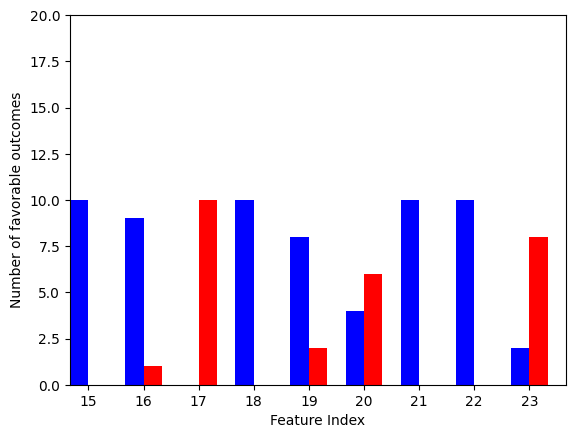

In [16]:
proportion_each_feature = []
for feature_idx in binary_features:
    n_fav_priv = np.sum((pred_train == 1) & (X_train[:,feature_idx] == 1))
    n_fav_unpr = np.sum((pred_train == 1) & (X_train[:,feature_idx] == 0))

    proportion_each_feature.append({"n_fav_priv": n_fav_priv, "n_fav_unpr": n_fav_unpr})

x_blue = 0.5 + 3 * np.arange(len(binary_features))
x_red = 1.5 + 3 * np.arange(len(binary_features))
y_blue = [d['n_fav_unpr'] for d in proportion_each_feature]
y_red = [d['n_fav_priv'] for d in proportion_each_feature]

fig, ax = plt.subplots()
ax.bar(x_blue, y_blue, color='blue', width=1, label='Unprivileged')
ax.bar(x_red, y_red, color='red', width=1, label='Privileged')
ax.set_xticks([1 + 3 * i for i in range(len(binary_features))])
ax.set_xticklabels([f'{idx}' for idx in binary_features])
ax.set_ylabel('Number of favorable outcomes')
ax.set_xlabel('Feature Index')

ax.set(xlim=(0, 3 * len(binary_features)), ylim=(0, max(y_blue + y_red) + 10))

plt.show()

In [17]:
aod_vals = []
aaod_vals = []
for feature_idx in binary_features:
    pred_train = model.predict(X_train)
    aod = compute_aod(y_train, pred_train, X_train[:,feature_idx])
    aaod = compute_aaod(y_train, pred_train, X_train[:,feature_idx])
    
    aod_vals.append(aod)
    aaod_vals.append(aaod)
    print(f'Feature {feature_idx}, AOD: {aod}, AAOD: {aaod}')

Feature 15, AOD: 0.02434408850967884, AAOD: 0.02434408850967884
Feature 16, AOD: -0.014861676841974258, AAOD: 0.02097165584564209
Feature 17, AOD: -0.018975747749209404, AAOD: 0.018975747749209404
Feature 18, AOD: 0.01807713881134987, AAOD: 0.01807713881134987
Feature 19, AOD: -0.0008056431543081999, AAOD: 0.007108164019882679
Feature 20, AOD: 0.0035368020180612803, AAOD: 0.0035368020180612803
Feature 21, AOD: 0.017572738230228424, AAOD: 0.017572738230228424
Feature 22, AOD: 0.020597083494067192, AAOD: 0.020597083494067192
Feature 23, AOD: -0.014351475983858109, AAOD: 0.014351475983858109


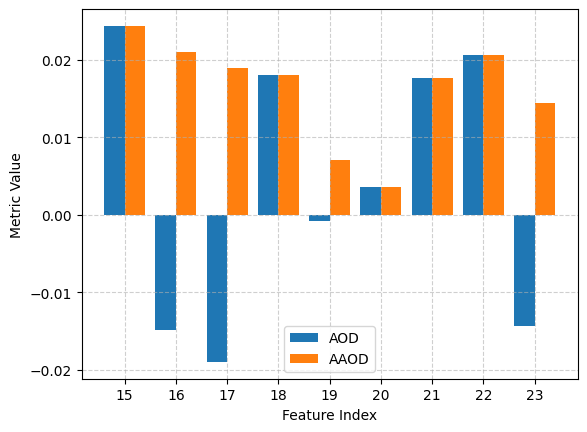

In [18]:
fig, ax = plt.subplots()
ax.bar(np.array(binary_features) - 0.2, aod_vals, width=0.4, label='AOD', color='C0')
ax.bar(np.array(binary_features) + 0.2, aaod_vals, width=0.4, label='AAOD', color='C1')
ax.set_xticks(binary_features)
ax.set_xticklabels([f'{idx}' for idx in binary_features])
ax.set_ylabel('Metric Value')
ax.set_xlabel('Feature Index')
ax.grid(ls='--', alpha=0.6)
ax.legend()
plt.show()

# Applying modifications into the LogisticRegression Function such that it supports regularizations.

In [19]:
std_model = LogisticRegression(lr=0.001, epochs=100)
l1_model = LogisticRegression(lr=0.001, epochs=100, penalty='l1', penalty_weight=0.1)
l2_model = LogisticRegression(lr=0.001, epochs=100, penalty='l2', penalty_weight=0.1)

std_model.fit(X_train, y_train)
l1_model.fit(X_train, y_train)
l2_model.fit(X_train, y_train)


In [20]:
models = {
    "Standard": std_model,
    "L1 Regularization": l1_model,
    "L2 Regularization": l2_model
}

for index_feature in binary_features:
    results = compare_fairness(models, X_test, y_test, index_feature)
    print(f'Feature {index_feature}:\n{results}\n')

Feature 15:
               Model Demographic Parity Equalized Odds
0           Standard        0.029720277    0.060018282
1  L1 Regularization         0.10198136     0.10500541
2  L2 Regularization        0.036713287    0.063109234

Feature 16:
               Model Demographic Parity Equalized Odds
0           Standard        -0.12241928    -0.39183253
1  L1 Regularization        -0.26897353    -0.06660592
2  L2 Regularization        -0.10846177    -0.41073266

Feature 17:
               Model Demographic Parity Equalized Odds
0           Standard         0.10983135     0.06361388
1  L1 Regularization         0.11312219      0.0989795
2  L2 Regularization         0.07034144    0.023507804

Feature 18:
               Model Demographic Parity Equalized Odds
0           Standard        -0.23168027    0.008827489
1  L1 Regularization        -0.16654332   -0.025898475
2  L2 Regularization        -0.12509254    0.049573224

Feature 19:
               Model Demographic Parity Equalized Odds
0

In [21]:
model_fair = LogisticRegression(lr=0.001, epochs=100, penalty='l2', penalty_weight=1.0, fair_penalty='Rpr', fair_penalty_weight=10)
model_fair.fit(X_train, y_train, S = X_train[:, 15], debug = True)
fair_pred_test = model_fair.predict(X_train)
fair_prob_test = model_fair.predict_probability(X_train)

Debug Info:
Base Cost: 0.6210971474647522, Reg Cost: 0.0013451941777020693, Fair Cost: 0.0009836552198976278
-----------------------------------------------------
Epoch 1/100, Cost: 0.6234260201454163
w: [-6.9306637e-03 -1.2851756e-03 -4.8936587e-03  1.8631597e-04
 -4.8332773e-03 -4.5007784e-03 -3.1273342e-03 -2.1701613e-03
 -7.1477774e-04 -3.4514837e-02 -3.3352077e-03 -1.3117469e-03
 -9.2233211e-04 -1.5684355e-03 -1.0817056e-03  9.2610926e-04
 -5.1239366e-04 -7.7206857e-04 -2.7097140e-06  1.2423843e-04
 -1.3744984e-03 -1.6394855e-05 -2.4442823e-04 -7.9225033e-04], b: -0.0009688274003565311
Debug Info:
Base Cost: 0.6163320541381836, Reg Cost: 0.0011505917645990849, Fair Cost: 0.0006094630225561559
-----------------------------------------------------
Epoch 2/100, Cost: 0.6180921196937561
w: [-1.1279510e-02  1.5980774e-03 -7.1146428e-03 -3.4089359e-03
 -6.9496036e-03 -5.6362893e-03 -3.6422836e-03 -1.7299844e-03
  4.8199357e-04 -2.8731968e-02 -3.9777472e-03 -1.4038994e-03
 -7.8134541e-04

In [22]:
model_not_fair = LogisticRegression(lr=0.001, epochs=100, penalty='l2', penalty_weight=1.0, fair_penalty='Rpr', fair_penalty_weight=0.0)
model_not_fair.fit(X_train, y_train, S = X_train[:, 15], debug = True)
not_fair_pred_test = model_not_fair.predict(X_train)
not_fair_prob_test = model_not_fair.predict_probability(X_train)

Debug Info:
Base Cost: 0.5871143937110901, Reg Cost: 0.0014837923226878047, Fair Cost: 0.0
-----------------------------------------------------
Epoch 1/100, Cost: 0.5885981917381287
w: [-6.8541435e-03  3.5803588e-03 -5.2151983e-03  7.5945398e-03
 -4.4206111e-03 -4.3524192e-03 -3.0319453e-03 -1.9774085e-03
 -2.9280040e-04 -3.5581362e-02 -3.3795794e-03 -1.4442141e-03
 -9.9802832e-04 -1.4537228e-03 -1.1109051e-03  3.3171230e-04
 -3.4684295e-04 -7.7431119e-04  2.4110119e-05  2.2746446e-04
 -1.4941454e-03 -8.6058444e-06 -3.5514982e-04 -5.6578382e-04], b: -0.0009385453886352479
Debug Info:
Base Cost: 0.5933780074119568, Reg Cost: 0.0019493303261697292, Fair Cost: 0.0
-----------------------------------------------------
Epoch 2/100, Cost: 0.5953273177146912
w: [-1.0986351e-02  1.2854455e-02 -7.7632004e-03  1.5231509e-02
 -6.6532502e-03 -5.5923024e-03 -3.7046729e-03 -1.5861908e-03
  1.0462640e-03 -3.5278898e-02 -4.2256750e-03 -1.5974204e-03
 -1.0095256e-03 -1.7208115e-03 -1.2695595e-03  9.63

In [23]:
print(f'AUC: {roc_auc_score(y_train, fair_prob_test)}')
print(f'AUC: {roc_auc_score(y_train, not_fair_prob_test)}')

AUC: 0.734098382559253
AUC: 0.7065001967057356


In [24]:
models = {
    "Rpr Fairness": model_fair,
    "Rpr No Fairness": model_not_fair
}

results = compare_fairness(models, X_train, y_train, 15)
print(f'Feature {15}:\n{results}\n')

Feature 15:
             Model Demographic Parity Equalized Odds
0     Rpr Fairness        0.006557377    0.010110704
1  Rpr No Fairness          0.0677308     0.11077605



In [10]:
print(f'AUC: {roc_auc_score(y_train, fair_prob_test)}')

AUC: 0.7125349802180835


In [36]:
def create_and_train_fair_models(fair_penalty_weight, sensitive_index):
    model = LogisticRegression(lr=0.001, epochs=100, penalty='l2', penalty_weight=1.0, fair_penalty='Rpr', fair_penalty_weight=fair_penalty_weight)
    model.fit(X_train, y_train, S = X_train[:, sensitive_index], debug = False)
    fair_pred_test = model.predict(X_train)
    fair_prob_test = model.predict_probability(X_train)
    return model, fair_pred_test, fair_prob_test

In [53]:
model = LogisticRegression(lr=0.001, epochs=100, penalty='l2', penalty_weight=1.0, fair_penalty='Rpr', fair_penalty_weight=1000.0)
model.fit(X_train, y_train, S = X_train[:, 15], debug = True)
fair_pred_test = model.predict(X_train)
fair_prob_test = model.predict_probability(X_train)

Debug Info:
Base Cost: 4.742630958557129, Reg Cost: 0.12318085879087448, Fair Cost: 0.0002244725328637287
-----------------------------------------------------
Epoch 1/100, Cost: 4.866036415100098
w: [-1.30647942e-02 -2.80191712e-02 -2.82205194e-02 -1.62009194e-01
 -1.23454835e-02 -1.51035935e-02 -1.01378635e-02 -1.11778593e-02
 -8.79886001e-03 -3.06852251e-01  5.83228422e-04 -1.31798293e-02
 -7.72179686e-04 -4.36839880e-03 -5.72648179e-03 -2.09896895e-03
 -2.16823374e-03 -6.19707815e-03 -6.53546769e-04  2.37412937e-03
 -6.53982861e-03  1.46876764e-03 -3.56475404e-03  1.09535766e-04], b: -0.004593255463987589
Debug Info:
Base Cost: nan, Reg Cost: nan, Fair Cost: nan
-----------------------------------------------------
Epoch 2/100, Cost: nan
w: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan], b: nan
Debug Info:
Base Cost: nan, Reg Cost: nan, Fair Cost: nan
-----------------------------------------------------
Epoch 3/100, Cost: nan
w: 

In [40]:
model_fair_1000, fair_pred_test_1000, fair_prob_test_1000 = create_and_train_fair_models(1000.0, 15)
model_fair_100, fair_pred_test_100, fair_prob_test_100 = create_and_train_fair_models(100.0, 15)
model_fair_10, fair_pred_test_10, fair_prob_test_10 = create_and_train_fair_models(10.0, 15)
model_fair_1, fair_pred_test_1, fair_prob_test_1 = create_and_train_fair_models(1.0, 15)
model_fair_0dot1, fair_pred_test_0dot1, fair_prob_test_0dot1 = create_and_train_fair_models(0.1, 15)
model_fair_00dot1, fair_pred_test_00dot1, fair_prob_test_00dot1 = create_and_train_fair_models(0.01, 15)
model_fair_000dot1, fair_pred_test_000dot1, fair_prob_test_000dot1 = create_and_train_fair_models(0.001, 15)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]


In [ ]:
models = {
    'fair_1000' : model_fair_1000,
    'fair_100' : model_fair_100,
    'fair_10' : model_fair_10,
    'fair_1' : model_fair_1,
    'fair_0.1' : model_fair_0dot1,
    'fair_0.01' : model_fair_00dot1,
    'fair_0.001' : model_fair_000dot1
}

results = compare_fairness(models, X_train, y_train, 15)
print(f'Feature {15}:\n{results}\n')

print(f'AUC: {roc_auc_score(y_train, fair_prob_test_1000)}')
print(f'AUC: {roc_auc_score(y_train, fair_prob_test_100)}')
print(f'AUC: {roc_auc_score(y_train, fair_prob_test_10)}')
print(f'AUC: {roc_auc_score(y_train, fair_prob_test_1)}')
print(f'AUC: {roc_auc_score(y_train, fair_prob_test_0dot1)}')
print(f'AUC: {roc_auc_score(y_train, fair_prob_test_00dot1)}')
print(f'AUC: {roc_auc_score(y_train, fair_prob_test_000dot1)}')

Feature 15:
        Model Demographic Parity Equalized Odds
0   fair_1000                0.0            0.0
1    fair_100        0.028300256    0.062449776
2     fair_10                0.0            0.0
3      fair_1         0.06988783     0.11024412
4    fair_0.1        0.004918033   0.0052513485
5   fair_0.01         0.07144089      0.1148822
6  fair_0.001        0.033908542     0.07071193



ValueError: Input contains NaN.